# Starbucks Capstone Project

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio

## Data Exploration

In [2]:
print('The portfolio dataframe has {} rows and {} columns'.format(portfolio.shape[0],portfolio.shape[1]))

# Analyzing the portfolio dataframe
portfolio.head()

The portfolio dataframe has 10 rows and 6 columns


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

<b>Notes:</b>
There are 4 BOGOs, 4 discount offers, and 2 informational offers.<br>
Information offers do not require any spend

In [4]:
# Going to convert column names later

offers_dict = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo1','4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo2',
               '3f207df678b143eea3cee63160fa8bed':'info1','9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo3',
               '0b1e1539f2cc45b7b9fa7c272da2e1d7':'disc1','2298d6c36e964ae4a3e7e9706d1fb8c2':'disc2',
               'fafdcd668e3743c1bb461111dcafc2a4':'disc3','5a8bc65990b245e5a138643cd4eb9837':'info2',
               'f19421c1d4aa40978ebb69ca19b0e20d':'bogo4','2906b810c7d4411798c6938adc9daaa5':'disc4'}

## Data Cleaning

In [5]:
def clean_portfolio(df=portfolio):
    
    # Creates channels df with dummy variables
    channels = df.channels.apply(lambda x: pd.Series([1]*len(x), index=x)).fillna(0, downcast='infer')
    
    # Joins df with the channels df
    df = pd.merge(df,channels,how='inner',left_index=True, right_index=True)
    
    df = df.drop(columns='channels')
    
    df = pd.get_dummies(df, columns =['offer_type'])
    
    df = df.rename(columns={'offer_type_bogo':'bogo',
                            'offer_type_discount':'discount',
                            'offer_type_informational':'informational'})
    
    # removing the 'id' column and assigning to id_
    id_ = df.pop('id')
    
    # re-inserting 'id' column into the first position
    df.insert(0,'id',id_)
    
    df.rename(columns={'id':'offer_id'},inplace=True)
    
    return df

In [6]:
portfolio = clean_portfolio()

print('The portfolio dataframe NOW has {} rows and {} columns'.format(portfolio.shape[0],portfolio.shape[1]))
portfolio.head()

The portfolio dataframe NOW has 10 rows and 11 columns


,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


# Profile

## Data Exploration

In [7]:
print('The profile dataframe has {} rows and {} columns'.format(profile.shape[0],profile.shape[1]))

# Initial analysis of the profile dataframe
profile.head()

The profile dataframe has 17000 rows and 5 columns


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
print(profile.describe())
print()
print(profile.info())

                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


The 'age' column has ages ranging from 18 - 118. 118 seems to be an outlier.<br> 

'became_member_on' is an int64 dtype when it should be a date; however, I would like to change
this date to show how long a person has had a membership

<AxesSubplot:xlabel='age'>

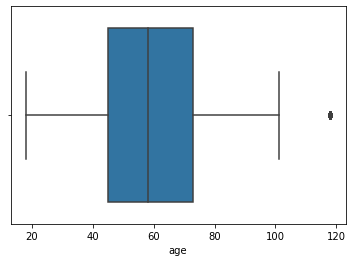

In [9]:
sns.boxplot(x=profile['age'])

In [10]:
profile[profile.age == 118].shape

(2175, 5)

In [11]:
profile[profile.age == 118].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

'gender' and 'income' both have NaN values in all columns where age == 118. These rows will be deleted

<AxesSubplot:xlabel='income'>

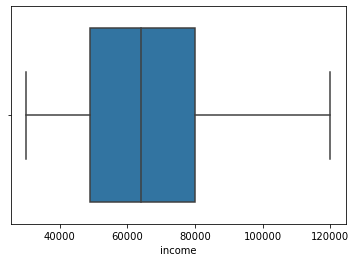

In [12]:
sns.boxplot(x=profile['income'])

In [13]:
round(profile.gender.value_counts(normalize=True)*100,2)

M    57.23
F    41.34
O     1.43
Name: gender, dtype: float64

~57% of customers are males, ~41% are females, and ~1% are unknown

## Data Cleaning

In [14]:
def clean_profile(df=profile):
    
    df = df[~(df.age == 118)].copy()
    df.gender = df.gender.map({'F':0,'M':1})
    
    basedate = pd.Timestamp('2018-07-26')

    # Updating the 'became_member_on' column to datetime type
    df.became_member_on = pd.to_datetime(df.became_member_on, format='%Y%m%d')

    df['became_member_on'] = df.apply(lambda x: (basedate - x.became_member_on).days, axis=1)

    # Renaming the column
    df.rename(columns={'became_member_on':'days_a_member'},inplace=True)
    
    # removing the 'id' column and assigning to id_
    id_ = df.pop('id')
    
    # re-inserting 'id' column into the first position
    df.insert(0,'id',id_)
    
    df.rename(columns={'id':'customer_id'},inplace=True)
    
    return df

In [15]:
profile = clean_profile()

profile.head()

,customer_id,gender,age,days_a_member,income
1,0610b486422d4921ae7d2bf64640c50b,0.0,55,376,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,0.0,75,443,100000.0
5,e2127556f4f64592b11af22de27a7932,1.0,68,91,70000.0
8,389bc3fa690240e798340f5a15918d5c,1.0,65,167,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,1.0,58,257,51000.0


# Transcript

In [16]:
print('The transcript dataframe has {} rows and {} columns'.format(transcript.shape[0],transcript.shape[1]))

# Initial analysis of the transcript dataframe
transcript.head()

The transcript dataframe has 306534 rows and 4 columns


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
# creates new df that normalizes the 'value' column
df2 = pd.json_normalize(transcript.value)

# joins new df with the old df and drops the 'value' column
transcript = pd.DataFrame.join(transcript,df2).drop(columns='value')

# sort values by customer and time
transcript = transcript.sort_values(by=['person','time'],ascending=True).reset_index(drop=True)

# Combining offer_id columns into 1 column and dropping the other
transcript.offer_id.fillna(transcript['offer id'], inplace=True)
transcript = transcript.drop(columns='offer id')

# Renaming columns
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [18]:
print("There were {} duplicated rows that were deleted".format(transcript.duplicated().sum()))

# Assuming that if the customer,event, time, etc are all the same, the row can be deleted
transcript = transcript[~transcript.duplicated()]

There were 397 duplicated rows that were deleted


In [19]:
transcript.head()

,customer_id,event,time,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN


We will use the transcript dataframe to create a few other dataframes.
1. transaction dataframe
2. event dataframe

### Transaction DataFrame

In [20]:
transaction = transcript[transcript.event == 'transaction']
transaction = transaction.groupby('customer_id').agg({'event':'count','amount':'mean'}).reset_index()
transaction.columns = ['customer_id','num_transactions','avg_spend']

In [21]:
transaction.head()

,customer_id,num_transactions,avg_spend
0,0009655768c64bdeb2e877511632db8f,8,15.950000
1,00116118485d4dfda04fdbaba9a87b5c,3,1.363333
2,0011e0d4e6b944f998e987f904e8c1e5,5,15.892000
3,0020c2b971eb4e9188eac86d93036a77,8,24.607500
4,0020ccbbb6d84e358d3414a3ff76cffd,12,12.837500


### Event DataFrame

In [22]:
event = transcript.groupby(['customer_id','offer_id','event']).offer_id.count().unstack().reset_index()
event = event.rename_axis(None, axis=1)
event = event.fillna(0)

In [23]:
event.head()

,customer_id,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0


### Joining Dataframes

In [24]:
df = pd.merge(event,portfolio,how='left',left_on='offer_id',right_on='offer_id')

In [25]:
df.head()

,customer_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,2,10,7,1,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,0,4,1,1,0,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,0,3,1,1,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,5,5,5,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,2,10,10,1,1,1,1,0,1,0


In [26]:
df = pd.merge(df,profile,how='left',left_on='customer_id',right_on='customer_id')

In [27]:
df.head()

,customer_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,gender,age,days_a_member,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,2,10,7,1,1,0,1,0,1,0,1.0,33.0,461.0,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,0,4,1,1,0,1,0,0,1,1.0,33.0,461.0,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,0,3,1,1,1,0,0,0,1,1.0,33.0,461.0,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,5,5,5,1,1,1,1,1,0,0,1.0,33.0,461.0,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,2,10,10,1,1,1,1,0,1,0,1.0,33.0,461.0,72000.0


In [28]:
df = pd.merge(df,transaction,how='left',left_on='customer_id',right_on='customer_id')

In [29]:
df

,customer_id,offer_id,offer completed,offer received,offer viewed,reward,difficulty,duration,email,mobile,...,web,bogo,discount,informational,gender,age,days_a_member,income,num_transactions,avg_spend
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,2,10,7,1,1,...,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.950000
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,0,4,1,1,...,1,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.950000
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,0,3,1,1,...,0,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.950000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,5,5,5,1,1,...,1,1,0,0,1.0,33.0,461.0,72000.0,8.0,15.950000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,2,10,10,1,1,...,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.0,2.0,2.0,5,5,5,1,1,...,1,1,0,0,1.0,34.0,549.0,34000.0,12.0,7.402500
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0,5,20,10,1,0,...,1,0,1,0,0.0,45.0,608.0,62000.0,15.0,15.071333
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3.0,3.0,3.0,2,10,7,1,1,...,1,0,1,0,0.0,45.0,608.0,62000.0,15.0,15.071333
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,5,5,7,1,1,...,1,1,0,0,0.0,45.0,608.0,62000.0,15.0,15.071333


In [30]:
# re-mapping the offer_id values
df.offer_id = df.offer_id.map(offers_dict)

# renaming columns without a '_'
df = df.rename(columns = {'offer completed':'offer_completed','offer received':'offer_received','offer viewed':'offer_viewed'})

In [31]:
df['received_viewed'] = df['offer_viewed']/df['offer_received']

# Less than 5% of the rows had values not exactly 1 or 0. We will round those values either up or down.
df['received_completed'] = round(df['offer_completed']/df['offer_received'])

In [32]:
df.head()

,customer_id,offer_id,offer_completed,offer_received,offer_viewed,reward,difficulty,duration,email,mobile,...,discount,informational,gender,age,days_a_member,income,num_transactions,avg_spend,received_viewed,received_completed
0,0009655768c64bdeb2e877511632db8f,disc4,1.0,1.0,0.0,2,10,7,1,1,...,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,info1,0.0,1.0,1.0,0,0,4,1,1,...,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,info2,0.0,1.0,1.0,0,0,3,1,1,...,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,bogo4,1.0,1.0,1.0,5,5,5,1,1,...,0,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,disc3,1.0,1.0,1.0,2,10,10,1,1,...,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0


In [33]:
df = df.drop(columns=['offer_completed','offer_received','offer_viewed'])

In [34]:
df.head()

,customer_id,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,gender,age,days_a_member,income,num_transactions,avg_spend,received_viewed,received_completed
0,0009655768c64bdeb2e877511632db8f,disc4,2,10,7,1,1,0,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,info1,0,0,4,1,1,0,1,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,info2,0,0,3,1,1,1,0,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,bogo4,5,5,5,1,1,1,1,1,0,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,disc3,2,10,10,1,1,1,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0


In [35]:
df.isna().sum()

customer_id              0
offer_id                 0
reward                   0
difficulty               0
duration                 0
email                    0
mobile                   0
social                   0
web                      0
bogo                     0
discount                 0
informational            0
gender                8835
age                   8066
days_a_member         8066
income                8066
num_transactions      1564
avg_spend             1564
received_viewed          0
received_completed       0
dtype: int64

In [36]:
df.num_transactions = df.num_transactions.fillna(0)

In [37]:
df.avg_spend = df.avg_spend.fillna(0)

In [38]:
df.gender.value_counts(normalize=True)

1.0    0.581143
0.0    0.418857
Name: gender, dtype: float64

In [39]:
df = df[~df.gender.isna()]

In [40]:
df.isna().sum()

customer_id           0
offer_id              0
reward                0
difficulty            0
duration              0
email                 0
mobile                0
social                0
web                   0
bogo                  0
discount              0
informational         0
gender                0
age                   0
days_a_member         0
income                0
num_transactions      0
avg_spend             0
received_viewed       0
received_completed    0
dtype: int64

In [41]:
df.shape

(54453, 20)

## Demographics

In [42]:
df.head()

,customer_id,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,gender,age,days_a_member,income,num_transactions,avg_spend,received_viewed,received_completed
0,0009655768c64bdeb2e877511632db8f,disc4,2,10,7,1,1,0,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,info1,0,0,4,1,1,0,1,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,info2,0,0,3,1,1,1,0,0,0,1,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,bogo4,5,5,5,1,1,1,1,1,0,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,disc3,2,10,10,1,1,1,1,0,1,0,1.0,33.0,461.0,72000.0,8.0,15.95,1.0,1.0


In [43]:
df.describe()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,gender,age,days_a_member,income,num_transactions,avg_spend,received_viewed,received_completed
count,54453.000000,54453.000000,54453.000000,54453.0,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000,54453.000000
mean,4.206582,7.721558,6.508677,1.0,0.898793,0.599343,0.799442,0.399592,0.400639,0.199769,0.581143,54.341102,521.894515,65423.961949,8.518686,14.904886,0.749303,0.465851
std,3.403229,5.547343,2.205709,0.0,0.301605,0.490036,0.400422,0.489819,0.490032,0.399830,0.493376,17.406976,419.764895,21660.305944,5.258575,16.347562,0.422444,0.498837
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,42.000000,207.000000,49000.000000,5.000000,3.682778,0.500000,0.000000
50%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,55.000000,357.000000,64000.000000,8.000000,13.987857,1.000000,0.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,66.000000,797.000000,80000.000000,12.000000,21.387500,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,1823.000000,120000.000000,36.000000,451.470000,1.000000,1.000000


In [44]:
df.columns

Index(['customer_id', 'offer_id', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'gender', 'age', 'days_a_member', 'income', 'num_transactions',
       'avg_spend', 'received_viewed', 'received_completed'],
      dtype='object')

In [45]:
plt.style.use('seaborn')

In [46]:
age_dist = dict(df.groupby('age')['received_completed'].sum()/df.groupby('age')['received_completed'].count())

Text(0, 0.5, 'Number of People')

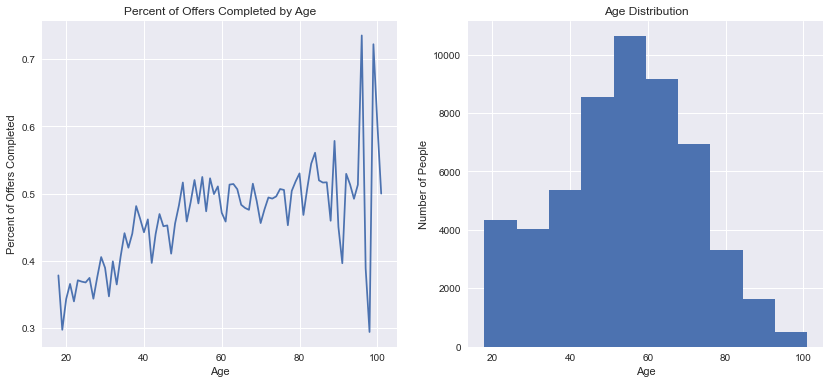

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                               figsize=(14,6))

ax1.plot(age_dist.keys(),age_dist.values())
ax1.set_title('Percent of Offers Completed by Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percent of Offers Completed')

ax2.hist(df.age)
ax2.set_title('Age Distribution')
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of People')

Older customers tended to complete their offers at a higher rate than younger customers.

The distribution of ages is normally distributed.

In [48]:
income_dist = dict(df.groupby('income')['received_completed'].sum()/df.groupby('income')['received_completed'].count())

Text(0, 0.5, 'Number of People')

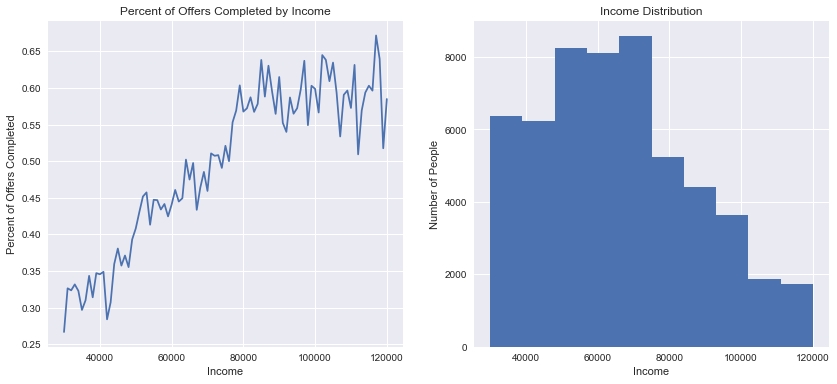

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                               figsize=(14,6))

ax1.plot(income_dist.keys(),income_dist.values())
ax1.set_title('Percent of Offers Completed by Income')
ax1.set_xlabel('Income')
ax1.set_ylabel('Percent of Offers Completed')

ax2.hist(df.income)
ax2.set_title('Income Distribution')
ax2.set_xlabel('Income')
ax2.set_ylabel('Number of People')

The more income a person makes, the more likely they are to complete an offer

The income is skewed to the right with the majority of people making between 55k and 75k.

In [50]:
duration_dist = dict(df.groupby('days_a_member')['received_completed'].mean())

Text(0, 0.5, 'Number of People')

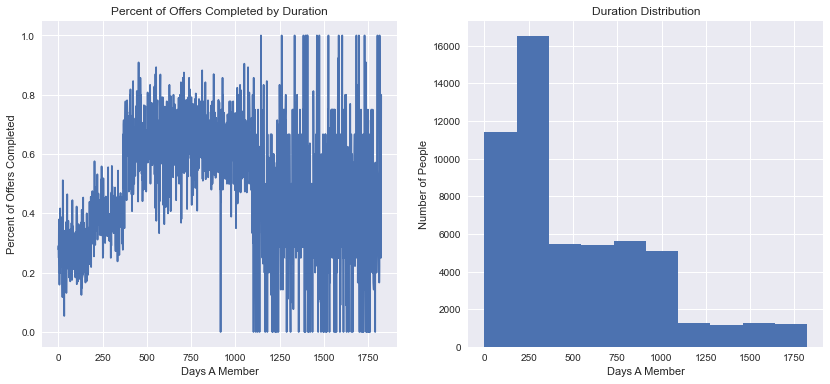

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                               figsize=(14,6))

ax1.plot(duration_dist.keys(),duration_dist.values())
ax1.set_title('Percent of Offers Completed by Duration')
ax1.set_xlabel('Days A Member')
ax1.set_ylabel('Percent of Offers Completed')

ax2.hist(df.days_a_member)
ax2.set_title('Duration Distribution')
ax2.set_xlabel('Days A Member')
ax2.set_ylabel('Number of People')

There is positive correlation between the length of time a customer has been a member vs the percent of offers they completed, until a customer has been a member more than 1100 days. After that, there is no apparent correlation.

There are a higher number of customers that have been members less than a year than customers greater than a year.



<AxesSubplot:xlabel='offer_id', ylabel='received_completed'>

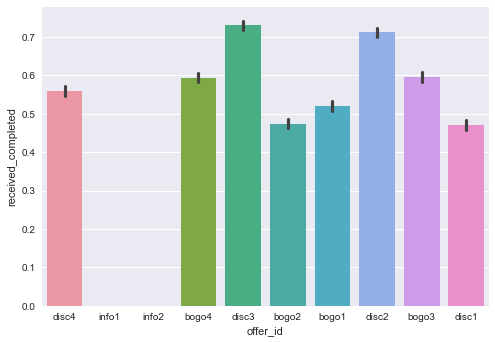

In [53]:
# Average amount of offers completed by offer type

sns.barplot(x='offer_id',y='received_completed',data=df)

<AxesSubplot:xlabel='gender', ylabel='received_completed'>

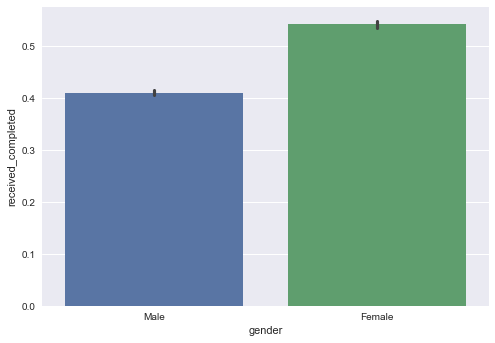

In [54]:
# Average amount of offers completed by gender

dems = df.copy()
dems.gender = dems.gender.map({0:'Female',1:'Male'})

sns.barplot(x='gender',y='received_completed',data=dems)

<AxesSubplot:xlabel='reward', ylabel='received_completed'>

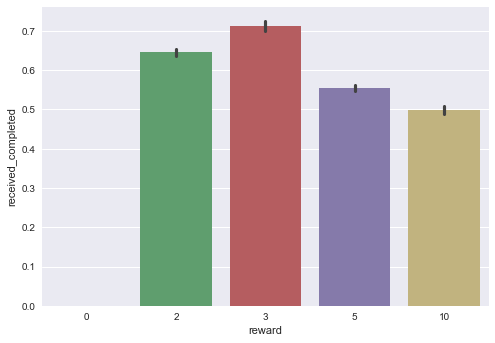

In [55]:
# Average amount of offers completed by reward

sns.barplot(x='reward',y='received_completed',data=df)

<AxesSubplot:xlabel='difficulty', ylabel='received_completed'>

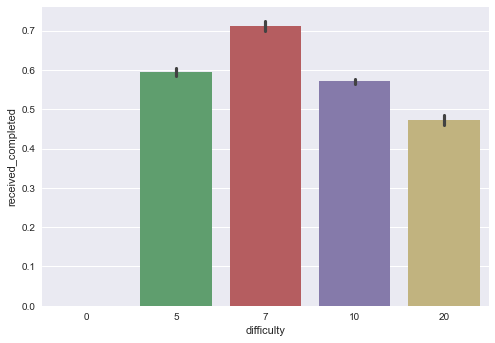

In [56]:
# Average amount of offers completed by difficulty

sns.barplot(x='difficulty',y='received_completed',data=df)

## Feature Scaling

In [57]:
# converting offer_ids to dummy variables
df = pd.get_dummies(df, columns=['offer_id'])

### Machine Learning

In [58]:
y = df['received_completed']
X = df.drop(columns=['customer_id','received_completed'])

In [59]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=10)

In [60]:
# ML libraries

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [61]:
logmodel = LogisticRegression(random_state=10)
logmodel.fit(X_train,y_train)

pred = logmodel.predict(X_test)

logmodel_accuracy = round(metrics.accuracy_score(y_test,pred)*100,2)

In [62]:
dtmodel = DecisionTreeClassifier(criterion = "gini", random_state = 10)
dtmodel.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
dt_pred = dtmodel.predict(X_test)

# Find Accuracy using accuracy_score method
dt_accuracy = round(metrics.accuracy_score(y_test, dt_pred) * 100, 2)

In [63]:
rfmodel = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 10)
rfmodel.fit(X_train, y_train) 
  
#Predict the value for new, unseen data
rf_pred = rfmodel.predict(X_test)

# Find Accuracy using accuracy_score method
rf_accuracy = round(metrics.accuracy_score(y_test, rf_pred) * 100, 2)

In [64]:
# Compare Several models according to their Accuracies
Model_Comparison = pd.DataFrame({
    'Model': ['Logistic Regression','Decision Tree', 'Random Forest'],
    'Score': [logmodel_accuracy, dt_accuracy, rf_accuracy]})
Model_Comparison_df = Model_Comparison.sort_values(by='Score', ascending=False)
Model_Comparison_df = Model_Comparison_df.set_index('Score')
Model_Comparison_df.reset_index()

,Score,Model
0,85.72,Random Forest
1,80.75,Decision Tree
2,73.06,Logistic Regression


In [65]:
#Generate confusion matrix for logistics regression model as it has maximum Accuracy
from sklearn.metrics import confusion_matrix
conf_mat_dtmodel = confusion_matrix(y_test,dt_pred)
conf_mat_dtmodel

array([[4824,  984],
       [1113, 3970]])